In [10]:
# Cell 1: Setup
import os, zipfile
data_zip = "retail_data.zip"  # change if needed
extract_dir = "retail_data_extracted"
os.makedirs(extract_dir, exist_ok=True)

# unzip (idempotent)
with zipfile.ZipFile(data_zip, 'r') as z:
    z.extractall(extract_dir)

# find first CSV inside extracted folder
csv_files = []
for root, dirs, files in os.walk(extract_dir):
    for f in files:
        if f.lower().endswith('.csv'):
            csv_files.append(os.path.join(root, f))
if not csv_files:
    raise FileNotFoundError("Can't find CSV inside retail_data.zip. Put CSV inside the zip named *.csv.")
csv_path = csv_files[0]
print("Using CSV:", csv_path)


Using CSV: retail_data_extracted/retail_data.csv


In [11]:


# Cell 2: Load & peek
import pandas as pd
pd.set_option('display.max_columns', 60)
df = pd.read_csv(csv_path, low_memory=False)
df.columns = [c.strip() for c in df.columns]   # clean names
print("Shape:", df.shape)
display(df.head(3).T)   # transposed for easy reading
# Save a copy of raw head
df.head(50).to_csv("data_head_sample.csv", index=False)


Shape: (302010, 30)


,0,1,2
Transaction_ID,8691788.0,2174773.0,6679610.0
Customer_ID,37249.0,69749.0,30192.0
Name,Michelle Harrington,Kelsey Hill,Scott Jensen
Email,Ebony39@gmail.com,Mark36@gmail.com,Shane85@gmail.com
Phone,1414786801.0,6852899987.0,8362160449.0
Address,3959 Amanda Burgs,82072 Dawn Centers,4133 Young Canyon
City,Dortmund,Nottingham,Geelong
State,Berlin,England,New South Wales
Zipcode,77985.0,99071.0,75929.0
Country,Germany,UK,Australia


In [12]:
# Cell 3: Cleaning & types
import numpy as np

# Standardize column names (lowercase + replace spaces)
df.columns = [c.strip() for c in df.columns]

# Convert numeric columns if present
num_cols = ['Amount','Total_Amount','Total_Purchases','Ratings','Age','Zipcode']
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Parse Date (flexible)
if 'Date' in df.columns:
    df['Date_parsed'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
else:
    df['Date_parsed'] = pd.NaT

# If many missing dates and Year+Month columns exist, build a date
if df['Date_parsed'].isna().mean() > 0.4 and 'Year' in df.columns and 'Month' in df.columns:
    month_map = {m:i for i,m in enumerate(['January','February','March','April','May','June',
                                          'July','August','September','October','November','December'],1)}
    def make_date(r):
        try:
            y = int(r['Year'])
            m = r['Month']
            if isinstance(m, str) and m.isdigit():
                m = int(m)
            elif isinstance(m, str):
                m = month_map.get(m,1)
            return pd.to_datetime(f"{y}-{int(m):02d}-01")
        except:
            return pd.NaT
    df.loc[df['Date_parsed'].isna(), 'Date_parsed'] = df[df['Date_parsed'].isna()].apply(make_date, axis=1)

# Quick missing stats
missing = df.isna().mean().sort_values(ascending=False).head(15)
print("Top missing rate columns:\n", missing)


/tmp/ipython-input-736559868.py:15: UserWarning: Parsing dates in %m/%d/%Y format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['Date_parsed'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')


Top missing rate columns:
 Date_parsed        0.394407
Name               0.001265
Phone              0.001199
Total_Purchases    0.001195
Date               0.001189
Amount             0.001182
Time               0.001159
Year               0.001159
Total_Amount       0.001159
Email              0.001149
Zipcode            0.001126
Shipping_Method    0.001116
Transaction_ID     0.001103
Gender             0.001050
Address            0.001043
dtype: float64


In [13]:
# Cell 4: Summary tables
print("Total rows:", len(df))
if 'Customer_ID' in df.columns:
    print("Unique customers:", df['Customer_ID'].nunique())

# Top categories & brands
if 'Product_Category' in df.columns:
    top_cats = df['Product_Category'].value_counts().head(20)
    print("\nTop Product Categories (by transactions):")
    print(top_cats)

if 'Product_Brand' in df.columns:
    top_brands = df['Product_Brand'].value_counts().head(20)
    print("\nTop Brands (by transactions):")
    print(top_brands)

# Save to CSV for reporting
if 'Product_Category' in df.columns:
    top_cats.to_csv("top_product_categories.csv")
if 'Product_Brand' in df.columns:
    top_brands.to_csv("top_brands.csv")


Total rows: 302010
Unique customers: 86766

Top Product Categories (by transactions):
Product_Category
Electronics    71196
Grocery        66786
Clothing       54741
Books          54622
Home Decor     54382
Name: count, dtype: int64

Top Brands (by transactions):
Product_Brand
Pepsi                30292
Coca-Cola            18392
Samsung              18376
Zara                 18370
HarperCollins        18353
Sony                 18319
Bed Bath & Beyond    18244
Adidas               18238
Home Depot           18145
Nike                 18139
Penguin Books        18138
Random House         18122
Nestle               18109
Apple                18073
IKEA                 17994
Whirepool             7445
Mitsubhisi            6724
BlueStar              2256
Name: count, dtype: int64


In [14]:
# Cell 5: RFM features
import pandas as pd
now = df['Date_parsed'].max() if df['Date_parsed'].notna().any() else pd.Timestamp.today()
min_date = df['Date_parsed'].dropna().min() if df['Date_parsed'].notna().any() else now - pd.Timedelta(days=365)

cust = df.groupby('Customer_ID').agg(
    LastPurchase=('Date_parsed','max'),
    NumTransactions=('Transaction_ID','count'),
    SumAmount=('Amount','sum')
).reset_index()

cust['LastPurchase'] = cust['LastPurchase'].fillna(min_date)
cust['RecencyDays'] = (now - cust['LastPurchase']).apply(lambda x: x.days)
cust['Frequency'] = cust['NumTransactions']
cust['Monetary'] = cust['SumAmount'].fillna(0)

cust[['Customer_ID','RecencyDays','Frequency','Monetary']].head(8).to_csv("rfm_sample.csv", index=False)
print("RFM sample saved to rfm_sample.csv")
display(cust.describe().T)


RFM sample saved to rfm_sample.csv


,count,mean,min,25%,50%,75%,max,std
Customer_ID,86766.0,55005.9125,10000.0,32502.25,55013.5,77512.75,99999.0,25985.457848
LastPurchase,86766,2023-10-08 21:23:42.723186432,2023-03-13 00:00:00,2023-07-19 00:00:00,2023-11-13 00:00:00,2024-01-18 00:00:00,2024-02-29 00:00:00,NaN
NumTransactions,86766.0,3.473354,0.0,2.0,3.0,5.0,13.0,1.761115
SumAmount,86766.0,886.188794,0.0,487.611082,815.112627,1201.167069,4588.737152,519.907716
RecencyDays,86766.0,143.108533,0.0,42.0,108.0,225.0,353.0,115.20362
Frequency,86766.0,3.473354,0.0,2.0,3.0,5.0,13.0,1.761115
Monetary,86766.0,886.188794,0.0,487.611082,815.112627,1201.167069,4588.737152,519.907716


In [15]:
# Cell 6: KMeans on RFM (log transforms)
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

rfm = cust[['RecencyDays','Frequency','Monetary']].copy()
rfm['Recency_log'] = np.log1p(rfm['RecencyDays'])
rfm['Monetary_log'] = np.log1p(rfm['Monetary'])
X = rfm[['Recency_log','Frequency','Monetary_log']].fillna(0)

scaler = StandardScaler()
Xs = scaler.fit_transform(X)

# Evaluate k (2..6) (for large data, it samples to speed up silhouette)
sample = Xs
if Xs.shape[0] > 30000:
    idx = np.random.choice(range(Xs.shape[0]), size=30000, replace=False)
    sample = Xs[idx]

best_k = 2; best_score = -1
for k in range(2,7):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    lab = km.fit_predict(sample)
    score = silhouette_score(sample, lab)
    print("k=",k," silhouette=",round(score,4))
    if score > best_score:
        best_score, best_k = score, k

print("Selected k =", best_k)
km = KMeans(n_clusters=best_k, random_state=42, n_init=20).fit(Xs)
cust['Segment'] = km.labels_
cust.to_csv("customers_with_segment.csv", index=False)
print("Customer segmentation saved to customers_with_segment.csv")


k= 2  silhouette= 0.3671
k= 3  silhouette= 0.3618
k= 4  silhouette= 0.341
k= 5  silhouette= 0.3171
k= 6  silhouette= 0.313
Selected k = 2
Customer segmentation saved to customers_with_segment.csv


 Segment  Recency_mean  Frequency_mean  Monetary_mean  CustomerCount
       1     81.593881        4.773213    1253.236892          43768
       0    205.724778        2.150216     512.567669          42998


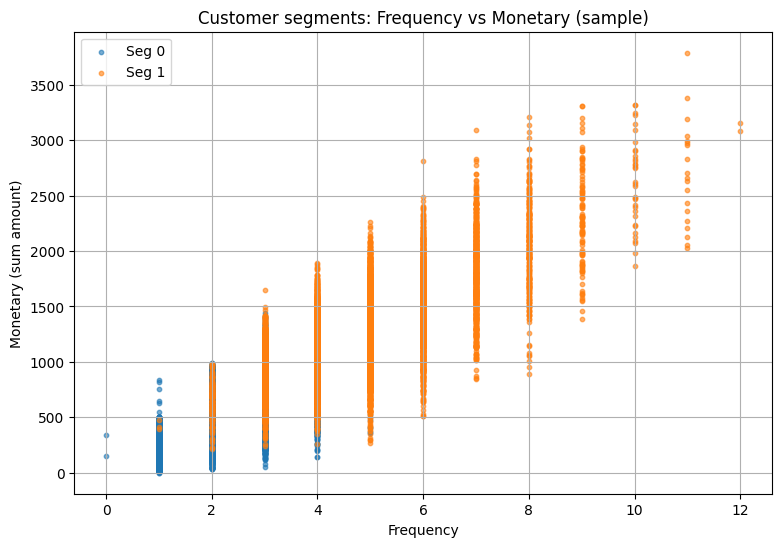

Saved: plots/segments_freq_monetary.png


In [16]:
# Cell 7: Segment summary + scatter plot
import matplotlib.pyplot as plt
seg_summary = cust.groupby('Segment').agg(
    Recency_mean=('RecencyDays','mean'),
    Frequency_mean=('Frequency','mean'),
    Monetary_mean=('Monetary','mean'),
    CustomerCount=('Customer_ID','count')
).reset_index().sort_values('Monetary_mean', ascending=False)
print(seg_summary.to_string(index=False))

# Plot: Frequency vs Monetary colored by segment (sample for speed)
plt.figure(figsize=(9,6))
sample = cust.sample(min(20000, len(cust)), random_state=42) if len(cust)>20000 else cust
for seg in sorted(sample['Segment'].unique()):
    s = sample[sample['Segment']==seg]
    plt.scatter(s['Frequency'], s['Monetary'], s=10, label=f"Seg {seg}", alpha=0.6)
plt.xlabel("Frequency")
plt.ylabel("Monetary (sum amount)")
plt.title("Customer segments: Frequency vs Monetary (sample)")
plt.legend()
plt.grid(True)
os.makedirs("plots", exist_ok=True)
plt.savefig("plots/segments_freq_monetary.png", dpi=150, bbox_inches='tight')
plt.show()
print("Saved: plots/segments_freq_monetary.png")


,Product_Category,Count,AvgAmount,AvgRating
2,Electronics,71114,255.418436,3.268857
3,Grocery,66700,255.229608,3.181739
1,Clothing,54689,254.912488,3.104266
0,Books,54559,255.047638,3.112428
4,Home Decor,54333,255.132881,3.109600


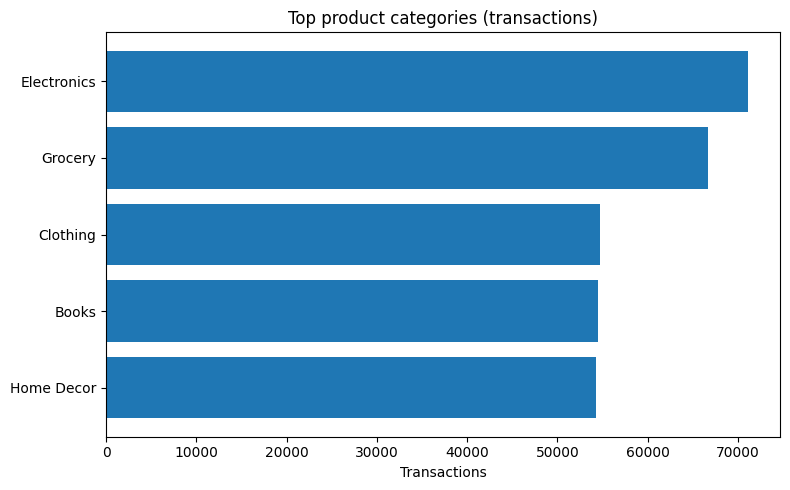

Saved: plots/top_categories.png


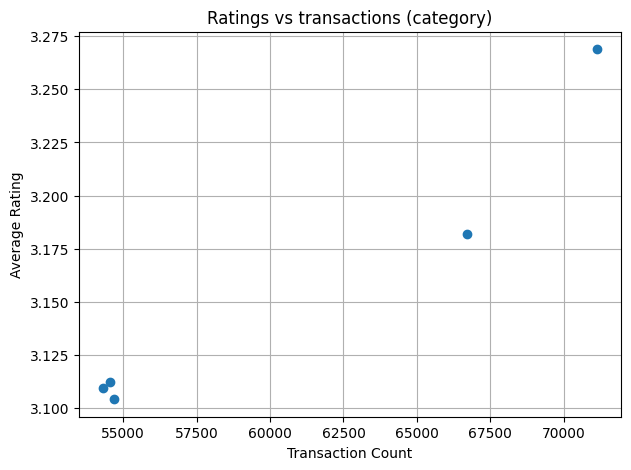

Saved: plots/ratings_vs_count.png


In [17]:
# Cell 8: Product performance & rating vs sales
if 'Product_Category' in df.columns:
    cat = df.groupby('Product_Category').agg(
        Count=('Transaction_ID','count'),
        AvgAmount=('Amount','mean'),
        AvgRating=('Ratings','mean')
    ).reset_index().sort_values('Count', ascending=False)
    display(cat.head(12))
    cat.head(12).to_csv("product_category_stats.csv", index=False)

    # Plot: top categories bar
    top = cat.head(10)
    plt.figure(figsize=(8,5))
    plt.barh(top['Product_Category'][::-1], top['Count'][::-1])
    plt.title("Top product categories (transactions)")
    plt.xlabel("Transactions")
    plt.tight_layout()
    plt.savefig("plots/top_categories.png", dpi=150)
    plt.show()
    print("Saved: plots/top_categories.png")

    # Plot: avg rating vs count scatter
    plt.figure(figsize=(7,5))
    plt.scatter(cat['Count'], cat['AvgRating'])
    plt.xlabel("Transaction Count")
    plt.ylabel("Average Rating")
    plt.title("Ratings vs transactions (category)")
    plt.grid(True)
    plt.savefig("plots/ratings_vs_count.png", dpi=150)
    plt.show()
    print("Saved: plots/ratings_vs_count.png")
else:
    print("No Product_Category column found.")


Order_Status     Delivered   Pending  Processing   Shipped
Shipping_Method                                           
Express           0.431973  0.163667    0.189949  0.214412
Same-Day          0.443747  0.159308    0.185818  0.211127
Standard          0.420158  0.165300    0.193274  0.221269


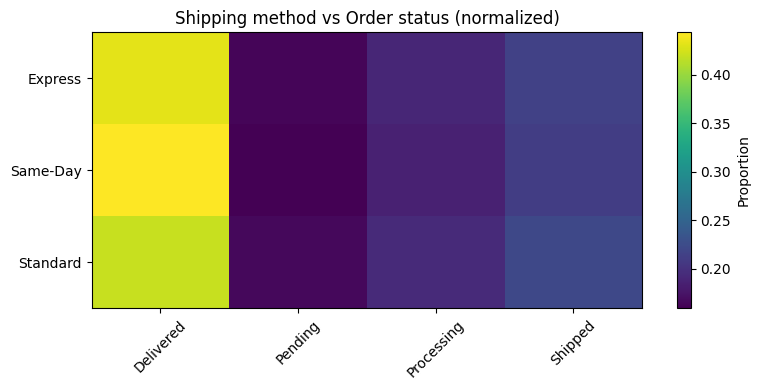

Saved: plots/shipping_vs_status_heatmap.png


In [18]:
# Cell 9: Shipping vs Order_Status
if 'Shipping_Method' in df.columns and 'Order_Status' in df.columns:
    ship_vs_status = pd.crosstab(df['Shipping_Method'], df['Order_Status'], normalize='index').fillna(0)
    ship_vs_status.to_csv("shipping_vs_status_normalized.csv")
    print(ship_vs_status)
    # Heatmap
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8,4))
    plt.imshow(ship_vs_status.values, interpolation='nearest', aspect='auto')
    plt.yticks(range(len(ship_vs_status.index)), ship_vs_status.index)
    plt.xticks(range(len(ship_vs_status.columns)), ship_vs_status.columns, rotation=45)
    plt.colorbar(label='Proportion')
    plt.title('Shipping method vs Order status (normalized)')
    plt.tight_layout()
    plt.savefig("plots/shipping_vs_status_heatmap.png", dpi=150)
    plt.show()
    print("Saved: plots/shipping_vs_status_heatmap.png")
else:
    print("Shipping_Method or Order_Status missing.")


,Payment_Method,AvgAmount,Count,CancelRate
1,Credit Card,255.440885,90010,0.0
2,Debit Card,255.167316,76711,0.0
3,PayPal,255.131889,60927,0.0
0,Cash,254.906487,73732,0.0


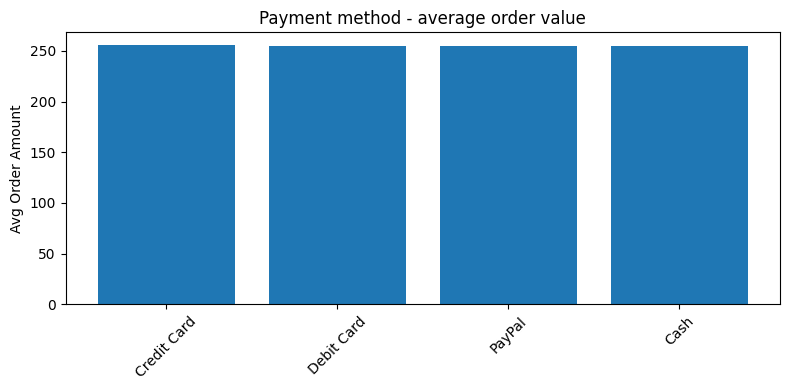

Saved: plots/payment_avg_amount.png


In [19]:
# Cell 10: Payment method stats
if 'Payment_Method' in df.columns:
    pay_stats = df.groupby('Payment_Method').agg(
        AvgAmount=('Amount','mean'),
        Count=('Transaction_ID','count'),
        CancelRate=('Order_Status', lambda x: (x=='Canceled').mean())
    ).reset_index().sort_values('AvgAmount', ascending=False)
    display(pay_stats)
    pay_stats.to_csv("payment_method_stats.csv", index=False)

    # Plot avg amount
    plt.figure(figsize=(8,4))
    plt.bar(pay_stats['Payment_Method'], pay_stats['AvgAmount'])
    plt.xticks(rotation=45)
    plt.ylabel("Avg Order Amount")
    plt.title("Payment method - average order value")
    plt.tight_layout()
    plt.savefig("plots/payment_avg_amount.png", dpi=150)
    plt.show()
    print("Saved: plots/payment_avg_amount.png")
else:
    print("Payment_Method column not found.")


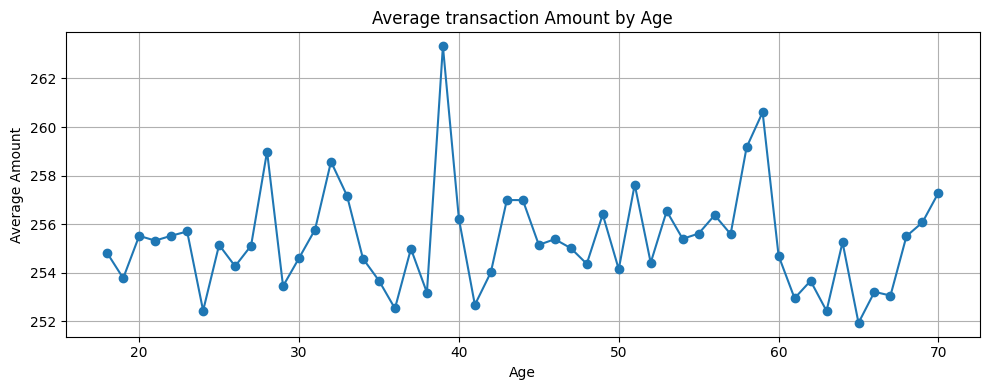

Saved: plots/spend_by_age.png


<Figure size 600x400 with 0 Axes>

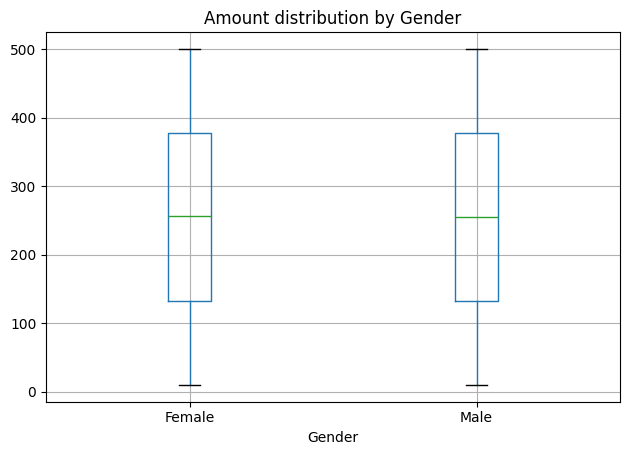

Saved: plots/spend_by_gender_box.png


In [20]:
# Cell 11: Spend by Age & Gender
import matplotlib.pyplot as plt
if 'Age' in df.columns and 'Amount' in df.columns:
    spend_age = df.dropna(subset=['Age','Amount']).groupby('Age')['Amount'].mean().reset_index()
    spend_age = spend_age[(spend_age['Age']>=12)&(spend_age['Age']<=90)]
    plt.figure(figsize=(10,4))
    plt.plot(spend_age['Age'], spend_age['Amount'], marker='o')
    plt.title("Average transaction Amount by Age")
    plt.xlabel("Age")
    plt.ylabel("Average Amount")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("plots/spend_by_age.png", dpi=150)
    plt.show()
    print("Saved: plots/spend_by_age.png")
else:
    print("Age/Amount columns missing for spend_by_age")

if 'Gender' in df.columns and 'Amount' in df.columns:
    plt.figure(figsize=(6,4))
    df.boxplot(column='Amount', by='Gender', showfliers=False)
    plt.title("Amount distribution by Gender")
    plt.suptitle('')
    plt.tight_layout()
    plt.savefig("plots/spend_by_gender_box.png", dpi=150)
    plt.show()
    print("Saved: plots/spend_by_gender_box.png")
else:
    print("Gender/Amount columns missing for spend_by_gender")


In [21]:
# Cell 12: Save report and PPTX
report = "OmniMart_EDA_report.md"
with open(report, "w", encoding="utf-8") as f:
    f.write("# OmniMart EDA — Executive Summary\n\n")
    f.write(f"Rows: {len(df)}\n\n")
    if 'Product_Category' in df.columns:
        f.write("## Top categories (top 8)\n")
        for c, cnt in df['Product_Category'].value_counts().head(8).items():
            f.write(f"- {c}: {cnt}\n")
    f.write("\n## Segment summary\n")
    f.write(seg_summary.to_markdown(index=False))
    f.write("\n\n## Notes\n- See `plots/` for visualizations.\n- See `customers_with_segment.csv` for assigned segments.\n")
print("Saved:", report)

# PPTX (optional)
try:
    from pptx import Presentation
    from pptx.util import Inches
    prs = Presentation()
    # Title slide
    s = prs.slides.add_slide(prs.slide_layouts[0])
    s.shapes.title.text = "OmniMart — EDA Executive Summary"
    s.placeholders[1].text = "Customer segmentation, product performance, operations insights"

    # Add top categories slide with image if exists
    for title, img in [("Top product categories","plots/top_categories.png"),
                       ("Customer segments","plots/segments_freq_monetary.png"),
                       ("Shipping vs Order Status","plots/shipping_vs_status_heatmap.png")]:
        slide = prs.slides.add_slide(prs.slide_layouts[5])
        slide.shapes.title.text = title
        if os.path.exists(img):
            slide.shapes.add_picture(img, Inches(1), Inches(1.1), height=Inches(4.0))

    pptx_file = "OmniMart_EDA_Report.pptx"
    prs.save(pptx_file)
    print("Saved PPTX:", pptx_file)
except Exception as e:
    print("python-pptx not available or error; install python-pptx if you want PPTX creation. Error:", e)


Saved: OmniMart_EDA_report.md
python-pptx not available or error; install python-pptx if you want PPTX creation. Error: No module named 'pptx'
